In [2]:
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq

In [5]:
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [6]:
print(llm.invoke("What is the capital of France?").content)

<think>

</think>

The capital of France is Paris.


In [7]:
print(llm.invoke("What is the capital of india tell me in detail?").content)

<think>
Okay, so I need to figure out the capital of India and provide a detailed explanation. Hmm, I remember that India is a country in South Asia, but I'm not entirely sure about its capital. I think it's Delhi, but I might be mixing it up with another city. Let me try to recall.

I know that Delhi is a very large and populous city in India. I've heard it's in the north part of the country. But wait, isn't Mumbai the financial hub? So maybe Mumbai isn't the capital. Then there's Bangalore, which is known for its tech industry. That doesn't sound like the capital either.

Wait, I think the capital is actually New Delhi, which is within Delhi. I've heard people refer to New Delhi as the capital. So perhaps Delhi is the state or the National Capital Territory, and New Delhi is the specific part that's the capital. That makes sense because sometimes cities have a specific area designated as the capital.

Let me think about other details. I remember that India gained independence from Br

In [8]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [9]:
search_tool.invoke("What is the capital of France?")

[{'title': 'Paris facts: the capital of France in history',
  'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
  'content': 'page 4\n\n===============\n\nHomeSpainSydneySan FranciscoParisLas VegasMaui\n\n Paris, France\n\nImage 1\n\nParis facts: Paris, the capital of France\n---------------------------------------------\n\nParis is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants).\n\nParis has 2.234 million inhabitants end 2011. She is the core of Ile de France region (12 million people). [...] Before Paris, the capital of France was Lyon (under the Romans). Paris first became the capital of France in 508 under King Clovis. After centuries with no unique capital of France, Paris retrieved its status of capital of France under King Philippe Auguste, who reigned between 1180 and 1223. You can see remains of the Philippe August Paris walls in the passageway between the Louvre parking and Louvre Museum [...] Paris remained the capital

In [10]:
my_code = """
x=10
y=x+10
print(y)
"""

In [13]:
pip install langchain-experimental

  Using cached langchain_experimental-0.3.4-py3-none-any.whl.metadata (1.7 kB)
Using cached langchain_experimental-0.3.4-py3-none-any.whl (209 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
from langchain_experimental.utilities import PythonREPL

In [15]:
repl=PythonREPL()

In [16]:
repl.run(my_code)

Python REPL can execute arbitrary code. Use with caution.


'20\n'

In [17]:
from typing import Annotated

In [18]:
from langchain_core.tools import tool

In [20]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

In [21]:
python_repl_tool.invoke("x=10\ny=x+10\nprint(y)")

'Successfully executed:\n```python\nx=10\ny=x+10\nprint(y)\n```\nStdout: 20\n'

In [22]:
python_repl_tool.invoke(my_code)

'Successfully executed:\n```python\n\nx=10\ny=x+10\nprint(y)\n\n```\nStdout: 20\n'

WE HAVE TWO SUB AGENT

RESEARCHER- internet

CODER- executing the code

In [23]:
members=["researcher","coder"]

In [24]:
members

['researcher', 'coder']

In [25]:
options = members+["FINISH"]

In [26]:
options

['researcher', 'coder', 'FINISH']

In [27]:
from typing import Literal

In [28]:
from typing_extensions import TypedDict

There is no routing logic

it is simply going to return the next candidate(next_agent)

this next is containig the next candidate name

In [29]:
class Router(TypedDict):
    next: Literal['researcher', 'coder', 'FINISH']

In [30]:
from langgraph.graph import MessagesState,StateGraph,START, END

this is a messagesstate which we are loading from the langgraph(inbuilt message state)

In [31]:
class State(MessagesState):
    next:str

In [32]:
class State(MessagesState):
    next:str
state={"messages": ["hi"], "next": "research_agent"}

In [33]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [34]:
print(system_prompt)

"
You are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.



In [35]:
messages = [{"role": "system", "content": system_prompt},] + state["messages"]

In [36]:
messages

[{'role': 'system',
  'content': '"\nYou are a supervisor, tasked with managing a conversation between the following workers: [\'researcher\', \'coder\']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n'},
 'hi']

In [37]:
llm_with_structure_output=llm.with_structured_output(Router)

In [38]:
llm_with_structure_output.invoke(messages)

{'next': 'researcher'}

In [39]:
from langgraph.types import Command

In [40]:
def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my response {'next': 'researcher'}
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
    
    # class State(MessagesState):
    #   next:str
    # output of the state: state={"messages": ["hi"], "next": "researcher"}
    
    return Command(goto=goto, update={"next":goto})

In [41]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage

In [42]:
def research_agent(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [43]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )
    

In [44]:
graph=StateGraph(State)

In [ ]:
graph.add_node("supervisor", supervisor_agent)

In [48]:
graph.add_node("researcher", research_agent)
graph.add_node("coder", coder_agent)

In [49]:
graph.add_edge(START, "supervisor")

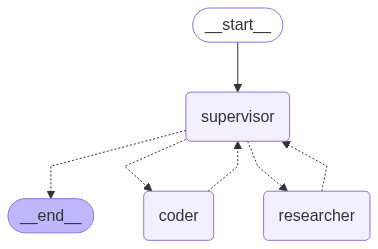

In [56]:
app=graph.compile()
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [57]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
researcher
((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************
(('researcher:9b75a4a7-613f-9cf5-9f23-6145f640e325',), {'agent': {'messages': [AIMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 224, 'prompt_tokens': 179, 'total_tokens': 403, 'completion_time': 0.814545455, 'prompt_time': 0.0112212, 'queue_time': 0.20043432900000002, 'total_time': 0.825766655}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--daa2d00d-7e8e-4eed-8966-07626c01fd92-0', usage_metadata={'input_tokens': 179, 'output_tokens': 224, 'total_tokens': 403})]}})
**********BELOW IS MY STATE***************
((), {'researcher': {'messages': [HumanMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={}, name='re

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '\n\nThe square root of 42 is approximately 6.4807. This value is obtained through approximation methods and prime factorization, confirming that √42 ≈ 6.4807.'}}

In [58]:
app.invoke({"messages": [("user", "what is an efficent python code to get prime number?")]}, subgraphs=True)

**********BELOW IS MY GOTO***************
researcher
**********BELOW IS MY GOTO***************
coder
**********BELOW IS MY GOTO***************
coder
**********BELOW IS MY GOTO***************
coder
**********BELOW IS MY GOTO***************
coder


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': ''}}